In [1]:
import numpy as np
import skeliner as sk
import matplotlib.pyplot as plt

from pywarper.surface import fit_sac_surface, build_mapping
from pywarper.warpers import warp_nodes, normalize_nodes, warp_skeleton
from pywarper.utils import read_sumbul_et_al_chat_bands
from pywarper.unwarper import unwarp_nodes, unwarp_skeleton


In [2]:
# data from Sümbül et al. 2014
# https://github.com/uygarsumbul/rgc
chat_top = read_sumbul_et_al_chat_bands("../tests/data/Image013-009_01_ChAT-TopBand-Mike.txt", unit="physical") # should be the off sac layer
chat_bottom = read_sumbul_et_al_chat_bands("../tests/data/Image013-009_01_ChAT-BottomBand-Mike.txt", unit="physical") # should be the on sac layer
# but the image can be flipped
if chat_top["z"].mean() > chat_bottom["z"].mean():
    off_sac = chat_top
    on_sac = chat_bottom
else:
    off_sac = chat_bottom
    on_sac = chat_top

skel = sk.io.load_swc("../tests/data/Image013-009_01_raw_latest_Uygar.swc")
# in the original matlab code, all data were in voxel space and converted to microns at the end
# but it makes more sense to work in microns from the beginning, so that there will be fewer unit conversion in between
voxel_resolution = np.array([0.4, 0.4, 0.5])  # in microns
skel.nodes *= voxel_resolution


In [3]:
# Fit surfaces with pygridfit under the hood
off_sac_surface, xgridmax, ygridmax = fit_sac_surface(x=off_sac['x'], y=off_sac['y'], z=off_sac['z'], smoothness=15)
on_sac_surface,  xgridmin, ygridmin = fit_sac_surface(x=on_sac['x'], y=on_sac['y'], z=on_sac['z'], smoothness=15)


In [4]:
# fit quasi-conformally mapping
arbor_boundaries = np.array([skel.nodes[:, 0].min(), skel.nodes[:, 0].max(), skel.nodes[:, 1].min(), skel.nodes[:, 1].max()])
surface_mapping = build_mapping(on_sac_surface, off_sac_surface, arbor_boundaries, conformal_jump=2, n_anchors=16, verbose=True)


↳ mapping ON (min) surface …
    done in 0.02 seconds.
↳ mapping OFF (max) surface …
    done in 0.02 seconds.


In [5]:
# warp the arbor
warped_skeleton = warp_skeleton(
    skel,
    surface_mapping,
    conformal_jump=2,
    z_profile_extent=[-25, 25], # the limits of the z profile, if None, it will be inferred.
    z_profile_bin_size=1., #  bin size (μm) in the z profile.
    z_profile_hdr_mass=0.95, # the mass of the histogram to be used for the z profile.
    xy_profile_extents=None, # the limits of the xy profile, if None, it will be inferred.
    xy_profile_bin_size=20., # bin size (μm) in the xy profile.
    verbose=True,
)


[pywarper] Warping skeleton...
    done in 0.40 seconds.
[skeliner] Warning: 58 nodes have zero radius; they were ignored when picking the estimator.


Skeleton local_ls error (mean / p95 / max): 0.0060 / 0.0257 / 0.0664
Skeleton optimize error on subset (mean / p95 / max): 5.2062e-04 / 1.9949e-03 / 2.6957e-02


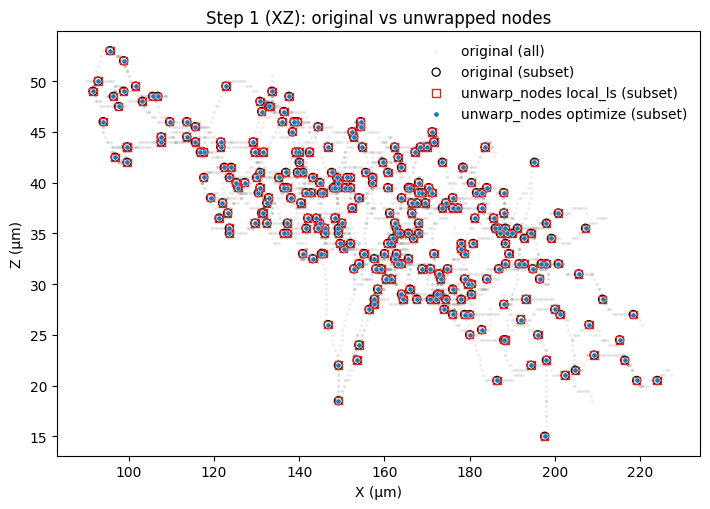

In [6]:
# unwarp demo (step 1): unwarp_nodes on warped skeleton nodes
# --------------------------------------------------------------------------- #
# Unwarp warped skeleton nodes back to the original coordinate frame.
# Compare the recovered nodes to the original skeleton nodes in XZ.

warped_nodes_norm = warped_skeleton.nodes
med_z_on = warped_skeleton.extra["med_z_on"]
med_z_off = warped_skeleton.extra["med_z_off"]

# option 1: fast approximate inverse (all nodes)
unwarped_skel_local = unwarp_nodes(
    warped_nodes_norm,
    surface_mapping,
    on_sac_pos=0,
    off_sac_pos=12,
    conformal_jump=2,
)

# option 2: inverse-by-optimization (iterative; use subset for notebook speed)
opt_idx = np.arange(0, len(warped_nodes_norm), 20)
unwarped_skel_opt = unwarp_nodes(
    warped_nodes_norm[opt_idx],
    surface_mapping,
    on_sac_pos=0,
    off_sac_pos=12,
    conformal_jump=2,
    method="optimize",
    max_evals_per_point=100,
    convergence_tol=1e-9,
    bound_xy_to_map=True,
)

err_skel_local = np.linalg.norm(unwarped_skel_local - skel.nodes, axis=1)
err_skel_opt = np.linalg.norm(unwarped_skel_opt - skel.nodes[opt_idx], axis=1)

print("Skeleton local_ls error (mean / p95 / max):", 
      f"{err_skel_local.mean():.4f} / {np.quantile(err_skel_local, 0.95):.4f} / {err_skel_local.max():.4f}")
print("Skeleton optimize error on subset (mean / p95 / max):", 
      f"{err_skel_opt.mean():.4e} / {np.quantile(err_skel_opt, 0.95):.4e} / {err_skel_opt.max():.4e}")

fig, ax = plt.subplots(figsize=(7.2, 5.2))

# background context: all original nodes
ax.scatter(
    skel.nodes[:, 0], skel.nodes[:, 2],
    s=2, alpha=0.12, c='0.65', label='original (all)', zorder=1,
)

# compare all methods on the same subset so marker overlap is readable
ax.scatter(
    skel.nodes[opt_idx, 0], skel.nodes[opt_idx, 2],
    s=34, facecolors='none', edgecolors='black', linewidths=0.9,
    label='original (subset)', zorder=2,
)
ax.scatter(
    unwarped_skel_local[opt_idx, 0], unwarped_skel_local[opt_idx, 2],
    s=28, marker='s', facecolors='none', edgecolors='C3', linewidths=1.0,
    label='unwarp_nodes local_ls (subset)', zorder=3,
)
ax.scatter(
    unwarped_skel_opt[:, 0], unwarped_skel_opt[:, 2],
    s=14, marker='o', c='C0', edgecolors='white', linewidths=0.3,
    label='unwarp_nodes optimize (subset)', zorder=4,
)

ax.set_title('Step 1 (XZ): original vs unwrapped nodes')
ax.set_xlabel('X (μm)')
ax.set_ylabel('Z (μm)')
ax.legend(frameon=False, loc='best')
fig.tight_layout()


Annotation local_ls error (mean / p95 / max): 0.0389 / 0.1822 / 1.0539
Annotation optimize error (mean / p95 / max): 1.7260e-12 / 6.7212e-12 / 1.0847e-10


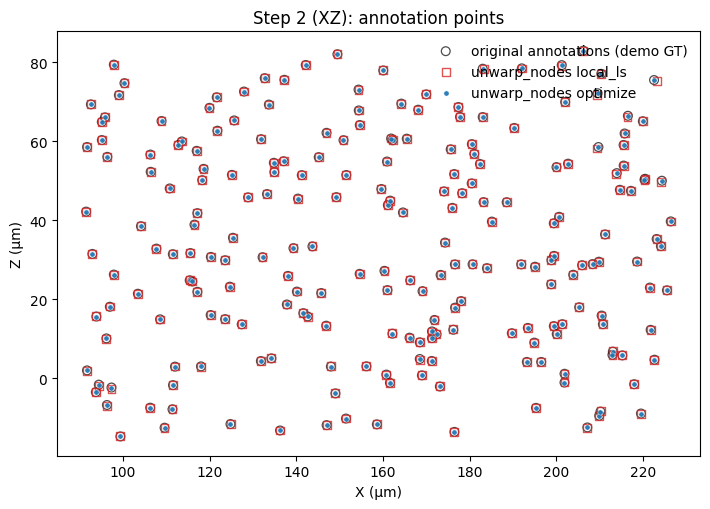

In [7]:
# unwarp demo (step 2): unwarp_nodes on annotation-like coordinates
# --------------------------------------------------------------------------- #
# Simulate annotations in warped space from arbitrary coordinates that are
# within mapping XY bounds but not constrained to skeleton nodes.
# Compare recovered coordinates in XZ.

rng = np.random.default_rng(7)
n_annotations = 220

x_min = float(surface_mapping["sampled_x_idx"].min())
x_max = float(surface_mapping["sampled_x_idx"].max())
y_min = float(surface_mapping["sampled_y_idx"].min())
y_max = float(surface_mapping["sampled_y_idx"].max())

# synthetic ground truth coordinates (not on original skeleton)
annot_orig = np.column_stack([
    rng.uniform(x_min + 2, x_max - 2, size=n_annotations),
    rng.uniform(y_min + 2, y_max - 2, size=n_annotations),
    rng.uniform(skel.nodes[:, 2].min() - 30, skel.nodes[:, 2].max() + 30, size=n_annotations),
])

# these are the coordinates that would be annotated in warped space
annot_prenorm, _, _ = warp_nodes(annot_orig, surface_mapping, conformal_jump=2)
annot_warped = normalize_nodes(
    annot_prenorm,
    med_z_on=med_z_on,
    med_z_off=med_z_off,
)

annot_unwarped_local = unwarp_nodes(
    annot_warped,
    surface_mapping,
    conformal_jump=2,
)
annot_unwarped_opt = unwarp_nodes(
    annot_warped,
    surface_mapping,
    conformal_jump=2,
    method="optimize",
    max_evals_per_point=100,
    convergence_tol=1e-9,
    bound_xy_to_map=True,
)

err_ann_local = np.linalg.norm(annot_unwarped_local - annot_orig, axis=1)
err_ann_opt = np.linalg.norm(annot_unwarped_opt - annot_orig, axis=1)

print("Annotation local_ls error (mean / p95 / max):", 
      f"{err_ann_local.mean():.4f} / {np.quantile(err_ann_local, 0.95):.4f} / {err_ann_local.max():.4f}")
print("Annotation optimize error (mean / p95 / max):", 
      f"{err_ann_opt.mean():.4e} / {np.quantile(err_ann_opt, 0.95):.4e} / {err_ann_opt.max():.4e}")

fig, ax = plt.subplots(figsize=(7.2, 5.2))

# marker stacking for readability at overlapping coordinates
ax.scatter(
    annot_orig[:, 0], annot_orig[:, 2],
    s=40, facecolors='none', edgecolors='black', linewidths=0.9,
    alpha=0.7, label='original annotations (demo GT)', zorder=2,
)
ax.scatter(
    annot_unwarped_local[:, 0], annot_unwarped_local[:, 2],
    s=32, marker='s', facecolors='none', edgecolors='C3', linewidths=1.0,
    alpha=0.8, label='unwarp_nodes local_ls', zorder=3,
)
ax.scatter(
    annot_unwarped_opt[:, 0], annot_unwarped_opt[:, 2],
    s=14, marker='o', c='C0', edgecolors='white', linewidths=0.3,
    alpha=0.95, label='unwarp_nodes optimize', zorder=4,
)

ax.set_title('Step 2 (XZ): annotation points')
ax.set_xlabel('X (μm)')
ax.set_ylabel('Z (μm)')
ax.legend(frameon=False, loc='best')
fig.tight_layout()


unwarp_skeleton local_ls error (mean / p95 / max): 0.0060 / 0.0257 / 0.0664


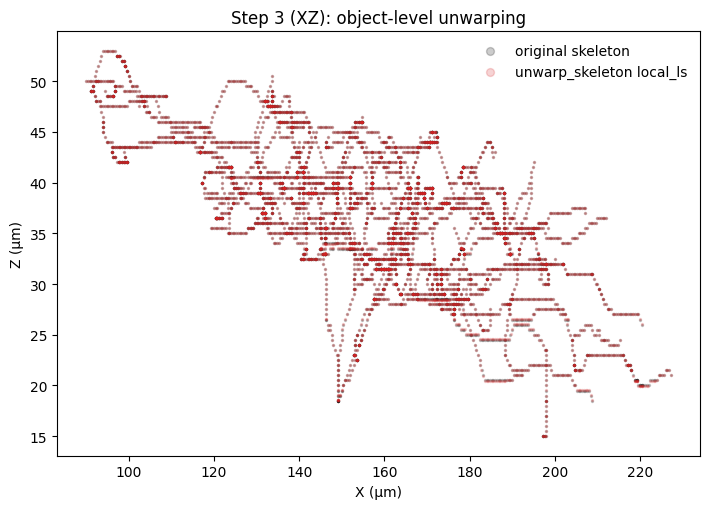

In [8]:
# unwarp demo (step 3): unwarp_skeleton (object-level API)
# --------------------------------------------------------------------------- #
# `unwarp_skeleton` inverts `warp_skeleton` directly on Skeleton objects.
# If `warp_skeleton` used voxel_resolution/skeleton_nodes_scale, pass the same values here.

unwarped_skeleton = unwarp_skeleton(
    warped_skeleton,
    surface_mapping,
    on_sac_pos=0,
    off_sac_pos=12,
    conformal_jump=2,
    method="local_ls",
)

err_obj = np.linalg.norm(unwarped_skeleton.nodes - skel.nodes, axis=1)
print("unwarp_skeleton local_ls error (mean / p95 / max):", 
      f"{err_obj.mean():.4f} / {np.quantile(err_obj, 0.95):.4f} / {err_obj.max():.4f}")

fig, ax = plt.subplots(figsize=(7.2, 5.2))
ax.scatter(
    skel.nodes[:, 0], skel.nodes[:, 2],
    s=2, alpha=0.20, c='black', label='original skeleton',
)
ax.scatter(
    unwarped_skeleton.nodes[:, 0], unwarped_skeleton.nodes[:, 2],
    s=2, alpha=0.20, c='C3', label='unwarp_skeleton local_ls',
)
ax.set_title('Step 3 (XZ): object-level unwarping')
ax.set_xlabel('X (μm)')
ax.set_ylabel('Z (μm)')
ax.legend(frameon=False, markerscale=4)
fig.tight_layout()


In [9]:
%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark


Last updated: 2026-02-16 16:06:53 CET

Python implementation: CPython
Python version       : 3.13.11
IPython version      : 9.10.0

matplotlib: 3.10.8
numpy     : 2.4.2
pywarper  : 0.2.5
skeliner  : 0.2.6

Watermark: 2.6.0

